# Worst-case risk on simple data

In this example, we consider the worst-case risk of the Logistic Regression model on a synthetic dataset $\{y, X_1, X_2\}$ under shifts in: $P(X_2|X_1)$, $P(X_1|X_2)$, $P(X_1, X_2)$.

In [1]:
from genrisk.shift import ConditionalShift

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt

In [2]:
def histhistplot(X, Y, color, title):
    fig = plt.figure(figsize=(5, 5))
    gs = GridSpec(4, 4)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    ax_joint.scatter(X, Y, c=color, s=10, cmap=plt.cm.coolwarm, alpha=0.3)
    ax_joint.set_xlim(-3, 3)
    ax_joint.set_ylim(-3, 3)
    ax_joint.set_xlabel('$X_1$')
    ax_joint.set_ylabel('$X_2$')
    ax_marg_x.hist(X, bins=np.linspace(-3, 3, 30), density=True)
    ax_marg_x.set_xlim(-3, 3)
    ax_marg_x.set_title(title)
    ax_marg_y.hist(Y, bins=np.linspace(-3, 3, 30), density=True, orientation="horizontal")
    ax_marg_y.set_ylim(-3, 3)
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.show()

Create a synthectic dataset

In [4]:
np.random.seed(0)
N = 20000
X = np.random.randn(N, 2)
y = (2*X[:, 1] > np.sin(2*X[:, 0]) + 0.2*np.random.randn(N))
theta = np.pi/6
rotation = [
    [ np.cos(theta),  np.sin(theta)],
    [-np.sin(theta),  np.cos(theta)]
]
X = X @ rotation

data = pd.DataFrame(X, columns=['X1', 'X2'])
data['y'] = y.astype('int')
data.index = pd.date_range('2020-01-01', periods=N, freq='D')
data

,X1,X2,y
2020-01-01,1.327636,1.228572,1
2020-01-02,-0.272835,2.430039,1
2020-01-03,2.105992,0.087432,0
2020-01-04,0.898479,0.343965,0
2020-01-05,-0.294689,0.303979,1
...,...,...,...
2074-09-29,-0.224552,-0.130133,1
2074-09-30,-1.009454,0.579753,1
2074-10-01,1.241320,-0.965952,0
2074-10-02,0.896748,2.469017,1


Plot the data distribution

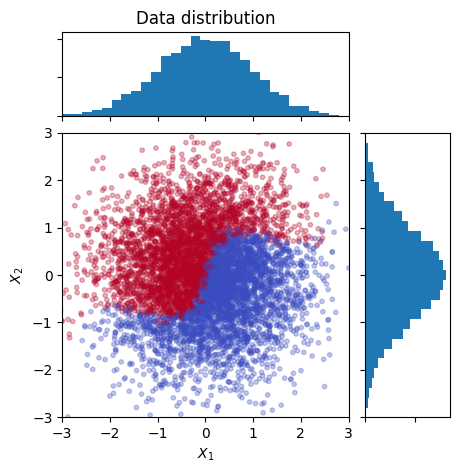

In [5]:
X_train, X_val, y_train, y_val = train_test_split(data[['X1', 'X2']], data['y'], test_size=0.33, )
histhistplot(X_val['X1'], X_val['X2'], y_val, 'Data distribution')

Train the logistic regression model to predict the target class.

In [6]:
target_model = LogisticRegression()
target_model.fit(X_train, y_train)
preds = target_model.predict_proba(X_val)[:, 1]
error_val = -(y_val * np.log(preds) + (1-y_val) * np.log(1-preds))
print(f'Average loss: {error_val.mean():.4f}')

Average loss: 0.2391


Define a shift in $P(X_2|X_1)$ and estimate the worst-case risk for alpha 0.9.

In [7]:
alpha = 0.9

In [8]:
shift_model = ConditionalShift(
    mutable_columns=['X2'],
    immutable_columns=['X1'],
    alpha=alpha, 
    cv=10,
)
shift_model.fit(X_val, error_val)
print(f'Worst-case risk for alpha {alpha} is {shift_model.risk:.4f}') 

  0%|          | 0/10 [00:00<?, ?it/s]

Worst-case risk for alpha 0.9 is 0.9993


Plot the worst subsample. We can see that the marginal distribution of $X_1$ is almost the same.

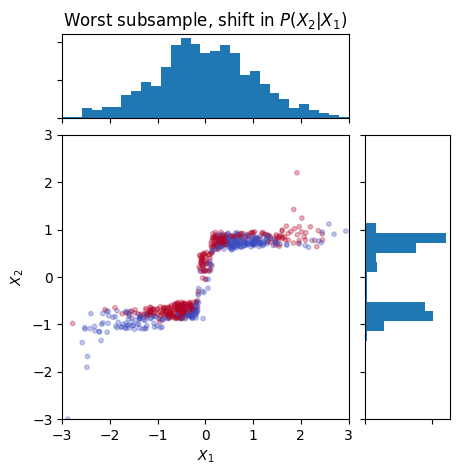

In [9]:
histhistplot(
    X_val['X1'][shift_model.mask], 
    X_val['X2'][shift_model.mask], 
    y_val[shift_model.mask], 
    'Worst subsample, shift in $P(X_2|X_1)$',
)

Define a shift in $P(X_1|X_2)$ and estimate the worst-case risk for alpha 0.9.

In [10]:
shift_model = ConditionalShift(
    mutable_columns=['X1'],
    immutable_columns=['X2'],
    alpha=alpha, 
    cv=10,
)
shift_model.fit(X_val, error_val)
print(f'Worst-case risk for alpha {alpha} is {shift_model.risk:.4f}') 

  0%|          | 0/10 [00:00<?, ?it/s]

Worst-case risk for alpha 0.9 is 0.9084


Plot the worst subsample. We can see that the marginal distribution of $X_2$ is almost the same.

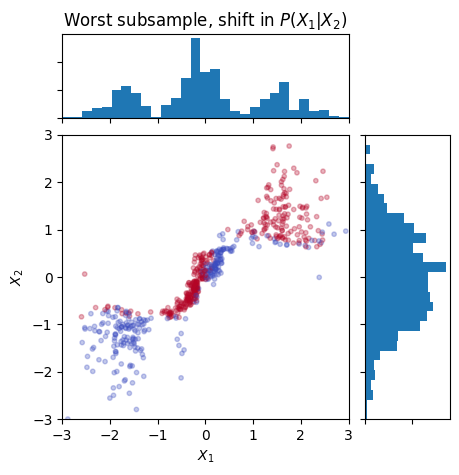

In [11]:
histhistplot(
    X_val['X1'][shift_model.mask], 
    X_val['X2'][shift_model.mask], 
    y_val[shift_model.mask], 
    'Worst subsample, shift in $P(X_1|X_2)$',
)

Define a shift in $P(X_1, X_2)$ and estimate the worst-case risk for alpha 0.9.

In [12]:
shift_model = ConditionalShift(
    mutable_columns=['X1', 'X2'],
    immutable_columns=[],
    alpha=alpha, 
    cv=10,
)
shift_model.fit(X_val, error_val)
print(f'Worst-case risk for alpha {alpha} is {shift_model.risk:.4f}') 

  0%|          | 0/10 [00:00<?, ?it/s]

Worst-case risk for alpha 0.9 is 1.1108


Plot the worst subsample. We can see that the marginal distributions are changed.

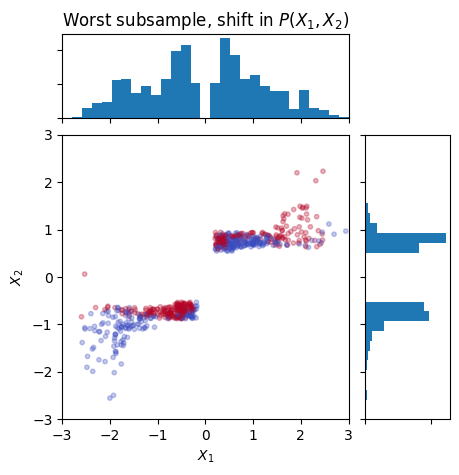

In [13]:
histhistplot(
    X_val['X1'][shift_model.mask], 
    X_val['X2'][shift_model.mask], 
    y_val[shift_model.mask], 
    'Worst subsample, shift in $P(X_1, X_2)$',
)

We can conclude, that the shift in $P(X_1, X_2)$ is more risky for the logistic regression than both $P(X_1|X_2)$ and $P(X_2|X_1)$.